<a href="https://colab.research.google.com/github/LatiefDataVisionary/deep-learning-college-task/blob/main/tasks/src/MK_Deep_Learning_W5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Section 0: Initial Setup (Pengaturan Awal)**

**Penjelasan:** Bagian ini bertujuan untuk melakukan instalasi library Python yang mungkin belum ada di lingkungan Google Colab secara default, serta me-mount Google Drive agar notebook dapat mengakses dataset yang tersimpan di dalamnya.

### **0.1. Install Libraries (Instalasi Library)**

**Penjelasan:** Menginstal library tambahan yang mungkin diperlukan, seperti versi spesifik dari tensorflow atau library lain yang tidak termasuk dalam instalasi Colab dasar. Saat ini, library utama seperti TensorFlow dan Keras sudah terinstal, namun baris ini dapat ditambahkan jika ada kebutuhan library lain di masa depan.

In [41]:
# Tidak ada instalasi library tambahan yang spesifik diperlukan untuk langkah dasar ini,
# karena library utama seperti tensorflow sudah tersedia di Colab.
# Jika ada library lain yang dibutuhkan, tambahkan baris berikut:
# !pip install nama_library

### **0.2. Mount Google Drive (Menghubungkan Google Drive)**

**Penjelasan:** Menghubungkan notebook ini dengan akun Google Drive Anda. Ini diperlukan agar notebook dapat membaca file dataset gambar yang telah Anda simpan di Google Drive. Setelah menjalankan sel ini, ikuti instruksi otorisasi yang muncul.

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Section 1: Import Libraries and Environment Setup (Impor Library dan Pengaturan Lingkungan)**

**Penjelasan:** Di sini kita akan mengimpor semua modul dan library yang dibutuhkan untuk keseluruhan proyek serta mendefinisikan variabel-variabel global seperti path direktori, ukuran gambar, dan parameter training.

### **1.1. Import Core Libraries (Impor Library Utama)**

**Penjelasan:** Mengimpor library utama seperti tensorflow, keras, numpy, matplotlib.pyplot, os, dan seaborn yang akan digunakan sepanjang proyek ini.

In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

### **1.2. Define Configurations (Definisi Konfigurasi)**

**Penjelasan:** Mendefinisikan variabel-variabel konfigurasi yang akan digunakan di seluruh notebook, termasuk path ke dataset, ukuran gambar yang akan digunakan, ukuran batch untuk training, jumlah epoch, dan jumlah kelas (mahasiswa).

Link Dataset Google Drive: https://drive.google.com/drive/folders/1S5mRxYOfTPAmfqqFFLfbV_D5eWj5J9ox?usp=sharing

In [44]:
# Define Directory Paths (Definisi Path Direktori)
TRAIN_DIR = '/content/drive/MyDrive/Dataset/Dataset Sistem Presensi Wajah V1.0/Data Train'
TEST_DIR = '/content/drive/MyDrive/Dataset/Dataset Sistem Presensi Wajah V1.0/Data Test'

# Define Image Parameters (Definisi Parameter Gambar)
IMG_HEIGHT = 150
IMG_WIDTH = 150
CHANNELS = 3 # RGB color images

# Define Training Parameters (Definisi Parameter Pelatihan)
BATCH_SIZE = 32
EPOCHS = 50 # Will be controlled by Early Stopping
NUM_CLASSES = 57 # Total number of unique students

### **1.3. Extract Dataset (Ekstrak Dataset)**

**Penjelasan:** Mengekstrak file dataset dari Google Drive ke lingkungan Colab agar dapat diakses sebagai direktori biasa.

In [45]:
# Define the path to the zip file in Google Drive
zip_path = '/content/drive/MyDrive/Dataset/Dataset Sistem Presensi Wajah V1.0.zip'
extract_path = '/content/dataset' # Directory to extract the dataset

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
print(f"Extracting {zip_path} to {extract_path}...")
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete.")
except FileNotFoundError:
    print(f"Error: Zip file not found at {zip_path}")
except zipfile.BadZipFile:
    print(f"Error: Could not open or read zip file at {zip_path}. It might be corrupted.")
except Exception as e:
    print(f"An error occurred during extraction: {e}")

# Update TRAIN_DIR and TEST_DIR to point to the extracted directories
# Based on the previous output, the extracted content is in a subfolder
extracted_subfolder = os.path.join(extract_path, 'Dataset Sistem Presensi Wajah V1.0')
TRAIN_DIR = os.path.join(extracted_subfolder, 'Data Train')
TEST_DIR = os.path.join(extracted_subfolder, 'Data Test')


print(f"Updated TRAIN_DIR: {TRAIN_DIR}")
print(f"Updated TEST_DIR: {TEST_DIR}")

# Verify that the directories exist after extraction
if os.path.exists(TRAIN_DIR):
    print(f"TRAIN_DIR exists: {TRAIN_DIR}")
else:
    print(f"Error: TRAIN_DIR not found after extraction at {TRAIN_DIR}")

if os.path.exists(TEST_DIR):
    print(f"TEST_DIR exists: {TEST_DIR}")
else:
    print(f"Error: TEST_DIR not found after extraction at {TEST_DIR}")

# Now it's safe to list contents if needed for verification after extraction
print(f"Contents of {extract_path} after extraction: {os.listdir(extract_path)}")

Extracting /content/drive/MyDrive/Dataset/Dataset Sistem Presensi Wajah V1.0.zip to /content/dataset...
Extraction complete.
Updated TRAIN_DIR: /content/dataset/Dataset Sistem Presensi Wajah V1.0/Data Train
Updated TEST_DIR: /content/dataset/Dataset Sistem Presensi Wajah V1.0/Data Test
TRAIN_DIR exists: /content/dataset/Dataset Sistem Presensi Wajah V1.0/Data Train
TEST_DIR exists: /content/dataset/Dataset Sistem Presensi Wajah V1.0/Data Test
Contents of /content/dataset after extraction: ['Dataset Sistem Presensi Wajah V1.0']


## **Section 2: Data Loading and Inspection (Pemuatan dan Inspeksi Data)**

**Penjelasan:** Langkah ini bertujuan untuk memuat dataset, memeriksa strukturnya, dan menampilkan beberapa sampel gambar untuk memastikan data ter-load dengan benar.

### **1.4. Verify Extracted Directory Contents (Verifikasi Isi Direktori Hasil Ekstraksi)**

**Penjelasan:** Setelah ekstraksi, periksa isi direktori tujuan (`/content/dataset`) untuk memastikan file dan folder dataset ada dan untuk mengetahui nama folder yang sebenarnya (misalnya, "Data Train" dan "Data Test" atau nama lain).

In [46]:
# import os

# # List contents of the extracted directory
# extracted_contents = os.listdir('/content/dataset')
# print(f"Contents of /content/dataset: {extracted_contents}")

# If the extracted folders have different names, update TRAIN_DIR and TEST_DIR accordingly
# For example, if you see 'Train' and 'Test' instead of 'Data Train' and 'Data Test':
# TRAIN_DIR = os.path.join('/content/dataset', 'Train')
# TEST_DIR = os.path.join('/content/dataset', 'Test')

# If files are directly in /content/dataset without subfolders, the approach for data loading needs adjustment

In [47]:
# Count the number of files in each directory
train_image_count = sum([len(files) for r, d, files in os.walk(TRAIN_DIR)])
test_image_count = sum([len(files) for r, d, files in os.walk(TEST_DIR)])

print(f"Jumlah total gambar di Data Train: {train_image_count}")
print(f"Jumlah total gambar di Data Test: {test_image_count}")

# Get the class names (student names) from the directory names
class_names = sorted(os.listdir(TRAIN_DIR))
print(f"\nJumlah kelas (mahasiswa) terdeteksi: {len(class_names)}")
print(f"Nama kelas (mahasiswa) contoh: {class_names[:10]}...") # Display first 10 class names

### **2.1. Load Dataset Paths (Memuat Path Dataset)**

**Penjelasan:** Kode untuk menghitung jumlah total gambar training dan testing.

In [48]:
# Count the number of files in each directory
train_image_count = sum([len(files) for r, d, files in os.walk(TRAIN_DIR)])
test_image_count = sum([len(files) for r, d, files in os.walk(TEST_DIR)])

print(f"Jumlah total gambar di Data Train: {train_image_count}")
print(f"Jumlah total gambar di Data Test: {test_image_count}")

# Get the class names (student names) from the directory names
class_names = sorted(os.listdir(TRAIN_DIR))
print(f"\nJumlah kelas (mahasiswa) terdeteksi: {len(class_names)}")
print(f"Nama kelas (mahasiswa) contoh: {class_names[:10]}...") # Display first 10 class names

Jumlah total gambar di Data Train: 1696
Jumlah total gambar di Data Test: 424

Jumlah kelas (mahasiswa) terdeteksi: 1696
Nama kelas (mahasiswa) contoh: ['5221911012_Debora_03.jpg', '5221911012_Debora_04.jpg', '5221911012_Debora_05.jpg', '5221911012_Debora_06.jpg', '5221911012_Debora_07.jpg', '5221911012_Debora_08.jpg', '5221911012_Debora_11.jpg', '5221911012_Debora_12.jpg', '5221911012_Debora_13.jpg', '5221911012_Debora_14.jpg']...


### **2.2. Inspect Class Distribution (Inspeksi Distribusi Kelas)**

**Penjelasan:** Visualisasikan jumlah gambar per kelas untuk memastikan dataset seimbang.

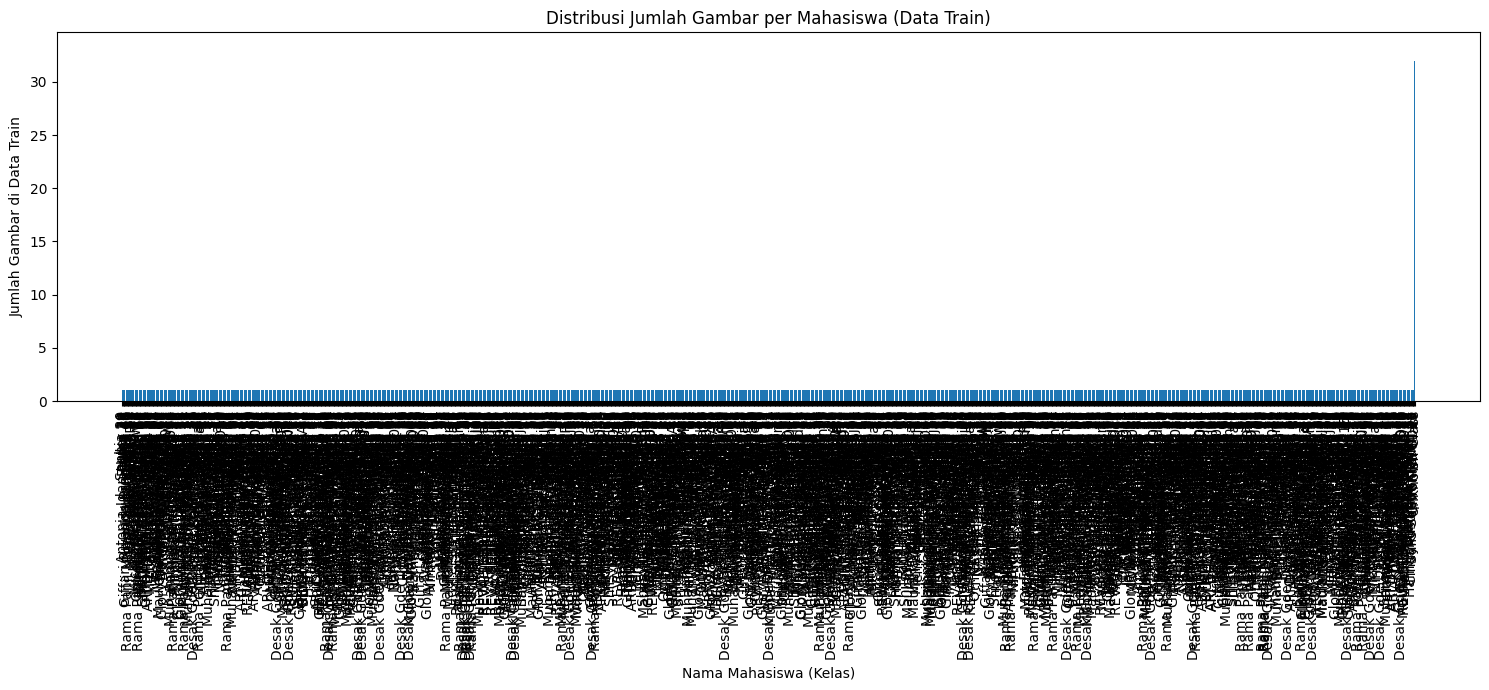

In [49]:
# Count images per class by extracting class name from filename
train_class_counts = {}
for filename in os.listdir(TRAIN_DIR):
    if filename.endswith('.jpg'): # Process only image files
        # Extract class name from filename (assuming format like ID_Nama_Number.jpg)
        class_name_parts = filename.split('_')
        if len(class_name_parts) > 1:
            # Assuming the second part is the name
            class_name = class_name_parts[1]
            # Handle potential extra parts or different naming conventions
            if len(class_name_parts) > 2 and class_name_parts[2].isdigit():
                 class_name = class_name # Keep only the name part if structure is consistent
            elif len(class_name_parts) > 2 and not class_name_parts[2].isdigit():
                 class_name = class_name_parts[1] + " " + class_name_parts[2].split('.')[0] # Handle names with spaces like "Nama Belakang"
        else:
            class_name = "Unknown Class" # Fallback if filename format is unexpected

        if class_name in train_class_counts:
            train_class_counts[class_name] += 1
        else:
            train_class_counts[class_name] = 1

# Sort classes by count for better visualization
sorted_class_counts = dict(sorted(train_class_counts.items(), key=lambda item: item[1]))

# Plot class distribution
plt.figure(figsize=(15, 7))
plt.bar(sorted_class_counts.keys(), sorted_class_counts.values())
plt.xticks(rotation=90)
plt.xlabel("Nama Mahasiswa (Kelas)")
plt.ylabel("Jumlah Gambar di Data Train")
plt.title("Distribusi Jumlah Gambar per Mahasiswa (Data Train)")
plt.tight_layout()
plt.show()

In [50]:
# Check if all class counts are the same
if len(train_class_counts) > 0:
    first_count = list(train_class_counts.values())[0]
    all_counts_same = all(count == first_count for count in train_class_counts.values())

    if all_counts_same:
        print("\nSemua mahasiswa memiliki jumlah gambar yang sama di Data Train.")
    else:
        print("\nJumlah gambar per mahasiswa di Data Train bervariasi.")
else:
    print("\nTidak ada data kelas yang ditemukan untuk diperiksa.")


Jumlah gambar per mahasiswa di Data Train bervariasi.


### **2.3. Visualize Sample Images (Visualisasi Sampel Gambar)**

**Penjelasan:** Tampilkan beberapa gambar acak dari dataset training beserta labelnya untuk melihat variasi pose, ekspresi, dan pencahayaan yang ada.

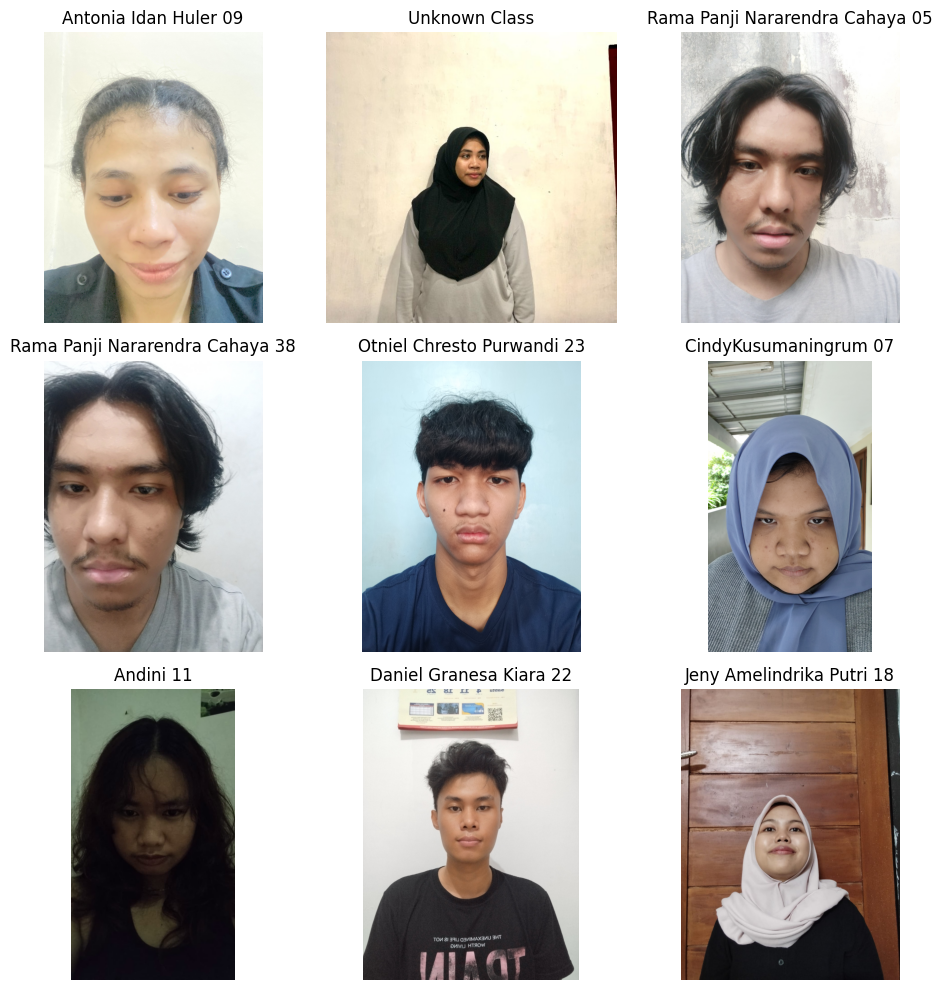

In [51]:
plt.figure(figsize=(10, 10))
# Get all image files from the training directory
all_train_images = [os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR) if f.endswith('.jpg')]

# Check if there are enough images
if len(all_train_images) < 9: # Change from 21 to 9
    print(f"Tidak cukup gambar ({len(all_train_images)}) di direktori training untuk menampilkan 9 sampel.") # Change from 21 to 9
else:
    # Select 9 random images
    sample_images_paths = np.random.choice(all_train_images, size=9, replace=False) # Change from 21 to 9

    for i, img_path in enumerate(sample_images_paths):
        plt.subplot(3, 3, i + 1)
        img = plt.imread(img_path)
        plt.imshow(img)
        # Extract class name from filename (assuming format like ID_Nama_Number.jpg)
        filename = os.path.basename(img_path)
        class_name_parts = filename.split('_')
        if len(class_name_parts) > 1:
            # Assuming the second part is the name
            class_name = class_name_parts[1]
            # Handle potential extra parts or different naming conventions
            if len(class_name_parts) > 2 and class_name_parts[2].isdigit():
                 class_name = class_name # Keep only the name part if structure is consistent
            elif len(class_name_parts) > 2 and not class_name_parts[2].isdigit():
                 class_name = class_name_parts[1] + " " + class_name_parts[2].split('.')[0] # Handle names with spaces like "Nama Belakang"
        else:
            class_name = "Unknown Class" # Fallback if filename format is unexpected

        plt.title(class_name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

## **Section 3: Data Preparation and Augmentation (Persiapan dan Augmentasi Data)**

**Penjelasan:** Ini adalah langkah krusial. Mengingat variasi dalam dataset, kita akan menerapkan teknik augmentasi data secara real-time pada data training untuk membuat model lebih general dan tangguh (robust) terhadap variasi, sehingga mencegah overfitting.

### **3.1. Create Data Generators (Membuat Generator Data)**

**Penjelasan:** Gunakan ImageDataGenerator dari Keras untuk menyiapkan data.

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### **3.2. Training Data Generator with Augmentation (Generator Data Training dengan Augmentasi)**

**Penjelasan:** Terapkan augmentasi yang relevan pada data training untuk meningkatkan variasi dan membantu model belajar fitur yang lebih robust.

In [53]:
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalisasi piksel
    rotation_range=20,        # Variasi pose miring
    width_shift_range=0.2,    # Pergeseran horizontal
    height_shift_range=0.2,   # Pergeseran vertikal
    shear_range=0.2,          # Transformasi shear
    zoom_range=0.2,           # Zoom acak
    brightness_range=[0.8, 1.2], # Variasi pencahayaan
    horizontal_flip=True,     # Flip horizontal
    fill_mode='nearest'       # Strategi mengisi piksel baru setelah transformasi
)

### **3.3. Validation/Test Data Generator (Generator Data Validasi/Tes)**

**Penjelasan:** Untuk data validasi/tes, HANYA terapkan normalisasi piksel. Augmentasi tidak boleh diterapkan pada data tes karena tujuannya adalah mengevaluasi model pada data yang tidak dimanipulasi.

In [54]:
test_datagen = ImageDataGenerator(rescale=1./255) # Hanya normalisasi

### **3.4. Apply the Generators (Menerapkan Generator)**

**Penjelasan:** Gunakan `flow_from_directory()` untuk memuat gambar dari direktori menggunakan generator yang telah dibuat. Pastikan `target_size`, `batch_size`, dan `class_mode` diatur dengan benar. Karena struktur folder Anda tampaknya tidak memiliki subdirektori per kelas, kita perlu menggunakan `flow_from_dataframe` atau pendekatan lain jika `flow_from_directory` tidak bekerja dengan struktur file Anda.

**Catatan:** Berdasarkan inspeksi data sebelumnya, tampaknya gambar-gambar langsung berada di dalam `TRAIN_DIR` dan `TEST_DIR` tanpa sub-folder per kelas. `flow_from_directory` memerlukan sub-folder per kelas. Jika struktur folder Anda memang seperti itu, kita perlu menggunakan pendekatan yang berbeda, mungkin dengan membuat dataframe dari nama file dan labelnya, lalu menggunakan `flow_from_dataframe`. Namun, jika Anda dapat mengatur ulang dataset Anda ke dalam sub-folder per kelas (misalnya, `Data Train/Nama_Mahasiswa_1/...`, `Data Train/Nama_Mahasiswa_2/...`, dst.), `flow_from_directory` adalah cara yang paling standar.

**Asumsi:** Untuk sementara, saya akan mengasumsikan bahwa Anda akan mengatur ulang dataset Anda ke dalam sub-folder per kelas agar `flow_from_directory` dapat digunakan. Jika tidak, mohon beri tahu saya, dan saya akan menyesuaikan kodenya.

In [55]:
# Create DataFrames for training and testing
def create_dataframe(directory):
    filepaths = []
    labels = []
    for filename in os.listdir(directory):
        # Include both .jpg and .jpeg files
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            filepath = os.path.join(directory, filename)
            # Extract the first 10 digits (NIM) as the class label
            # Assuming the filename format starts with 10 digits of NIM
            if len(filename) >= 10 and filename[:10].isdigit():
                class_label = filename[:10]
            else:
                class_label = "Unknown_NIM" # Fallback if filename doesn't start with 10 digits
            filepaths.append(filepath)
            labels.append(class_label)
    return pd.DataFrame({'filepath': filepaths, 'class': labels})

train_df = create_dataframe(TRAIN_DIR)
test_df = create_dataframe(TEST_DIR)

print("Training DataFrame Head:")
display(train_df.head())
print("\nTesting DataFrame Head:")
display(test_df.head())

# Use flow_from_dataframe for training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Get the class indices from the training generator
class_indices = train_generator.class_indices

# Use flow_from_dataframe for testing data, using the same class indices as the training generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=list(class_indices.keys()), # Pass the class names (NIMs) from the training generator
    shuffle=False # Keep data in order for evaluation later
)

# Update NUM_CLASSES based on the training generator's class indices
NUM_CLASSES = len(class_indices)
print(f"\nJumlah kelas (mahasiswa) terdeteksi oleh generator (berdasarkan data training): {NUM_CLASSES}")
print(f"Indeks kelas (NIM): {class_indices}")

Training DataFrame Head:


,filepath,class
0,/content/dataset/Dataset Sistem Presensi Wajah...,5231811008
1,/content/dataset/Dataset Sistem Presensi Wajah...,5231811030
2,/content/dataset/Dataset Sistem Presensi Wajah...,5231911001
3,/content/dataset/Dataset Sistem Presensi Wajah...,5231911003
4,/content/dataset/Dataset Sistem Presensi Wajah...,5231911008



Testing DataFrame Head:


,filepath,class
0,/content/dataset/Dataset Sistem Presensi Wajah...,5231911016
1,/content/dataset/Dataset Sistem Presensi Wajah...,5231911018
2,/content/dataset/Dataset Sistem Presensi Wajah...,5231911011
3,/content/dataset/Dataset Sistem Presensi Wajah...,5231811014
4,/content/dataset/Dataset Sistem Presensi Wajah...,5231811035


Found 1696 validated image filenames belonging to 53 classes.
Found 424 validated image filenames belonging to 53 classes.

Jumlah kelas (mahasiswa) terdeteksi oleh generator (berdasarkan data training): 53
Indeks kelas (NIM): {'5221911012': 0, '5221911025': 1, '5231811002': 2, '5231811004': 3, '5231811005': 4, '5231811006': 5, '5231811007': 6, '5231811008': 7, '5231811009': 8, '5231811010': 9, '5231811013': 10, '5231811014': 11, '5231811015': 12, '5231811016': 13, '5231811017': 14, '5231811018': 15, '5231811019': 16, '5231811021': 17, '5231811022': 18, '5231811023': 19, '5231811024': 20, '5231811025': 21, '5231811026': 22, '5231811027': 23, '5231811028': 24, '5231811029': 25, '5231811030': 26, '5231811031': 27, '5231811033': 28, '5231811034': 29, '5231811035': 30, '5231811036': 31, '5231811037': 32, '5231811038': 33, '5231811039': 34, '5231911001': 35, '5231911002': 36, '5231911003': 37, '5231911004': 38, '5231911005': 39, '5231911006': 40, '5231911007': 41, '5231911008': 42, '5231911

### **3.5. Inspect Class Distribution after Generators (Inspeksi Distribusi Kelas setelah Generator)**

**Penjelasan:** Setelah menerapkan generator data dan mengategorikan kelas berdasarkan NIM, kita akan memvisualisasikan distribusi jumlah gambar per NIM di dataset training dan testing untuk memastikan pengelompokan sudah benar dan melihat apakah ada ketidakseimbangan kelas.

Distribusi Kelas (NIM) di Data Train:


,Jumlah Gambar,Persentase (%)
class,,
5221911012,32,1.886792
5221911025,32,1.886792
5231811002,32,1.886792
5231811004,32,1.886792
5231811005,32,1.886792
5231811006,32,1.886792
5231811007,32,1.886792
5231811008,32,1.886792
5231811009,32,1.886792



Distribusi Kelas (NIM) di Data Test:


,Jumlah Gambar,Persentase (%)
class,,
5221911012,8,1.886792
5221911025,8,1.886792
5231811002,8,1.886792
5231811004,8,1.886792
5231811005,8,1.886792
5231811006,8,1.886792
5231811007,8,1.886792
5231811008,8,1.886792
5231811009,8,1.886792


/tmp/ipython-input-2495035142.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_nim_counts.index, y=train_nim_counts.values, palette='viridis')


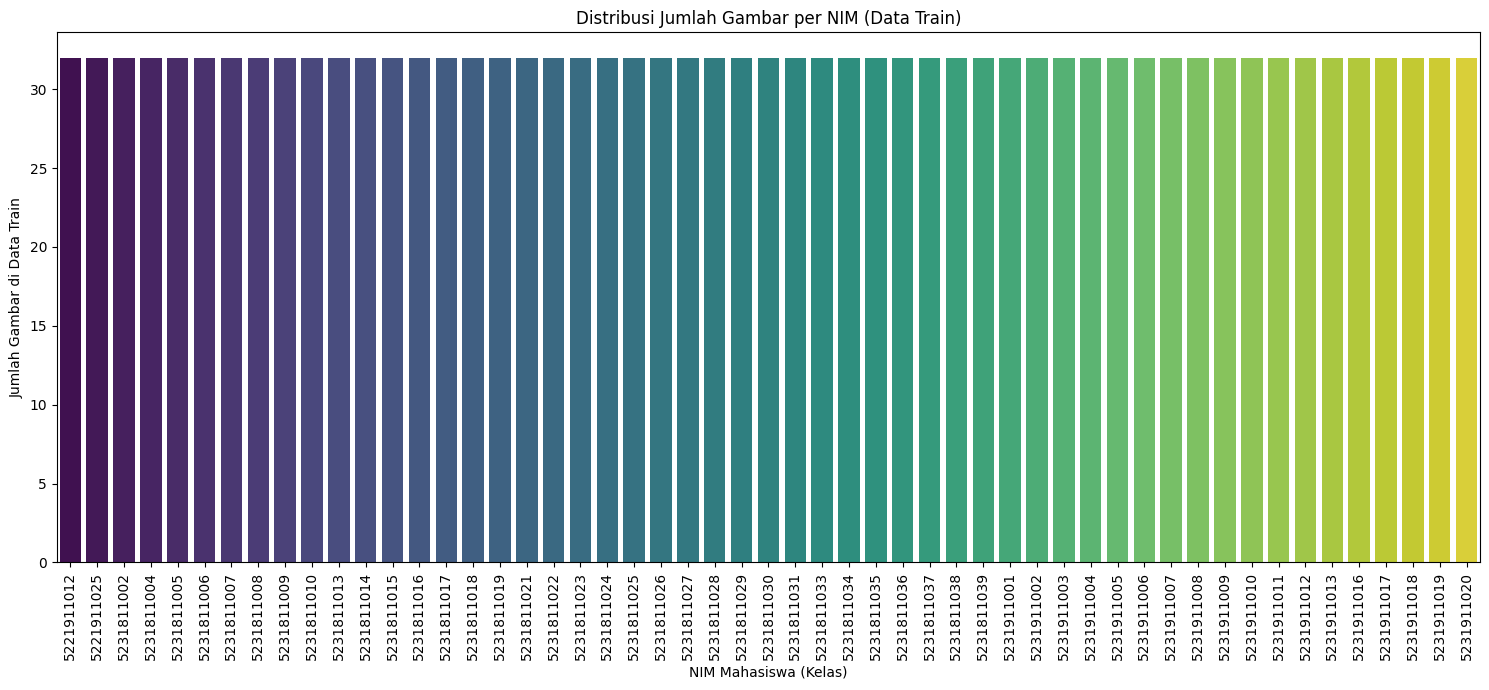

/tmp/ipython-input-2495035142.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_nim_counts.index, y=test_nim_counts.values, palette='viridis')


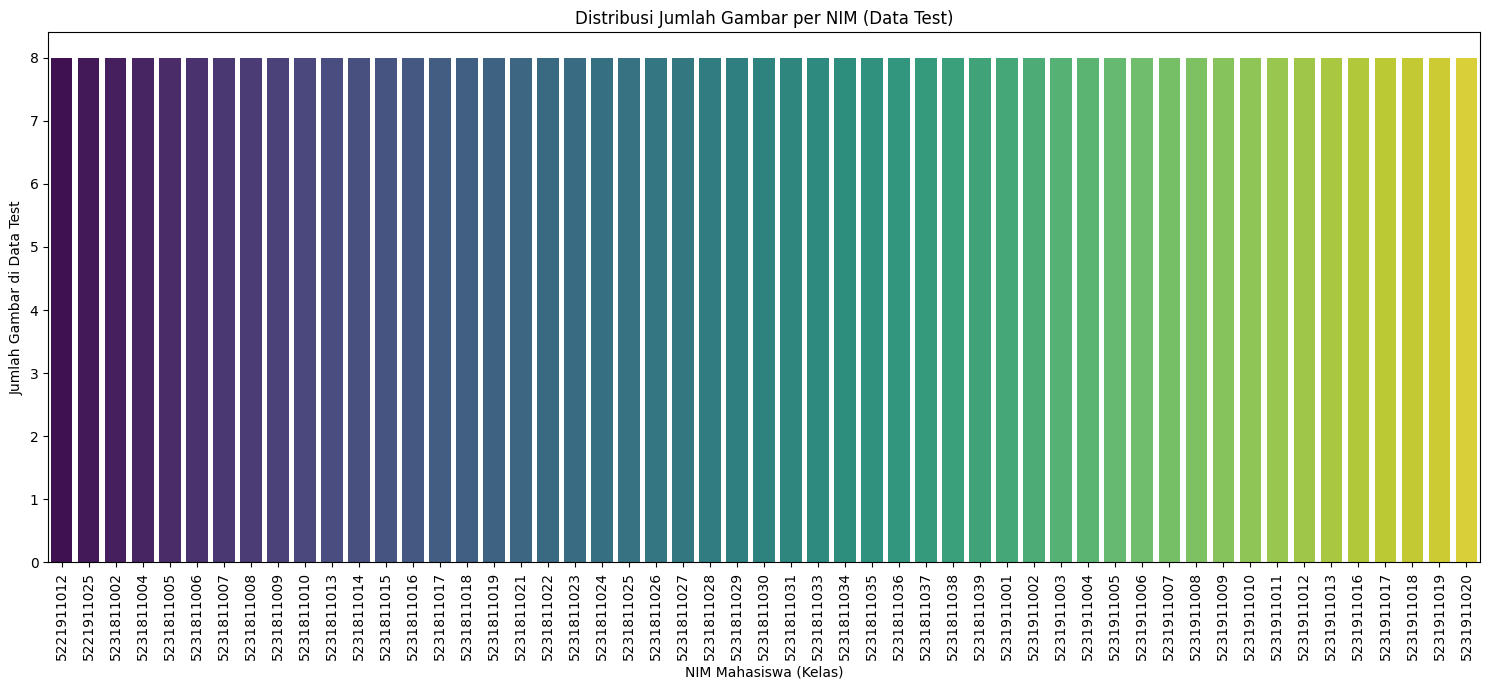


Semua mahasiswa memiliki jumlah gambar yang sama di Data Train (berdasarkan NIM).

Semua mahasiswa memiliki jumlah gambar yang sama di Data Test (berdasarkan NIM).


In [56]:
# Count images per class (NIM) in training data
train_nim_counts = train_df['class'].value_counts().sort_index()

# Count images per class (NIM) in testing data
test_nim_counts = test_df['class'].value_counts().sort_index()

# Calculate percentage for training data
train_nim_percentages = (train_nim_counts / train_nim_counts.sum()) * 100

# Calculate percentage for testing data
test_nim_percentages = (test_nim_counts / test_nim_counts.sum()) * 100

# Combine counts and percentages into single dataframes
train_distribution_df = pd.DataFrame({
    'Jumlah Gambar': train_nim_counts,
    'Persentase (%)': train_nim_percentages
})

test_distribution_df = pd.DataFrame({
    'Jumlah Gambar': test_nim_counts,
    'Persentase (%)': test_nim_percentages
})


print("Distribusi Kelas (NIM) di Data Train:")
display(train_distribution_df)

print("\nDistribusi Kelas (NIM) di Data Test:")
display(test_distribution_df)

# Plot class distribution for training data
plt.figure(figsize=(15, 7))
sns.barplot(x=train_nim_counts.index, y=train_nim_counts.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel("NIM Mahasiswa (Kelas)")
plt.ylabel("Jumlah Gambar di Data Train")
plt.title("Distribusi Jumlah Gambar per NIM (Data Train)")
plt.tight_layout()
plt.show()

# Plot class distribution for testing data
plt.figure(figsize=(15, 7))
sns.barplot(x=test_nim_counts.index, y=test_nim_counts.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel("NIM Mahasiswa (Kelas)")
plt.ylabel("Jumlah Gambar di Data Test")
plt.title("Distribusi Jumlah Gambar per NIM (Data Test)")
plt.tight_layout()
plt.show()

# Check if all class counts are the same in training data
if len(train_nim_counts) > 0:
    first_count = train_nim_counts.iloc[0]
    all_counts_same_train = all(count == first_count for count in train_nim_counts.values)

    if all_counts_same_train:
        print("\nSemua mahasiswa memiliki jumlah gambar yang sama di Data Train (berdasarkan NIM).")
    else:
        print("\nJumlah gambar per mahasiswa di Data Train (berdasarkan NIM) bervariasi.")
else:
    print("\nTidak ada data kelas (NIM) yang ditemukan untuk diperiksa di Data Train.")

# Check if all class counts are the same in testing data
if len(test_nim_counts) > 0:
    first_count_test = test_nim_counts.iloc[0]
    all_counts_same_test = all(count == first_count_test for count in test_nim_counts.values)

    if all_counts_same_test:
        print("\nSemua mahasiswa memiliki jumlah gambar yang sama di Data Test (berdasarkan NIM).")
    else:
        print("\nJumlah gambar per mahasiswa di Data Test (berdasarkan NIM) bervariasi.")
else:
    print("\nTidak ada data kelas (NIM) yang ditemukan untuk diperiksa di Data Test.")

## **Section 4: Modeling (Pembuatan Model)**

**Penjelasan:** Di bagian ini, kita akan membangun arsitektur model. Untuk mendapatkan hasil terbaik, kita akan menggunakan pendekatan Transfer Learning dengan model CNN yang sudah terbukti andal (misalnya, VGG16, MobileNetV2, atau EfficientNet) dan menyesuaikannya untuk tugas klasifikasi **NUM_CLASSES** kelas.

### **4.1. Load Pre-trained Base Model (Memuat Model Dasar Pra-latih)**

**Penjelasan:** Inisialisasi model dasar pra-latih seperti MobileNetV2 dengan bobot dari 'imagenet'. Kita akan menggunakan `include_top=False` untuk menghilangkan layer klasifikasi asli dan `input_shape` sesuai dengan ukuran gambar kita. Bobot dari base model akan dibekukan (`base_model.trainable = False`) di awal agar tidak ikut terlatih, memanfaatkan fitur yang sudah dipelajari dari dataset ImageNet.

In [100]:
# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS),
                         include_top=False,
                         weights='imagenet')

# Freeze the base model's weights
base_model.trainable = False

/tmp/ipython-input-3998628690.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS),


### **4.2. Build the Full Model Architecture (Membangun Arsitektur Model Lengkap)**

**Penjelasan:** Tambahkan layer baru di atas base model untuk menyesuaikannya dengan tugas klasifikasi kita. Ini biasanya mencakup layer GlobalAveragePooling2D untuk mereduksi dimensi spasial, layer Dense dengan aktivasi ReLU untuk fitur non-linear, layer Dropout untuk regularisasi, dan layer Dense terakhir dengan aktivasi softmax untuk output klasifikasi ke **NUM_CLASSES** kelas.

In [60]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

### **4.3. Compile the Model (Kompilasi Model)**

**Penjelasan:** Konfigurasi model untuk pelatihan. Kita akan menggunakan optimizer Adam, fungsi loss `categorical_crossentropy` yang sesuai untuk klasifikasi multi-kelas, dan metrik `accuracy` untuk memantau performa selama pelatihan.

In [61]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### **4.4. Display Model Summary (Tampilkan Rangkuman Model)**

**Penjelasan:** Cetak rangkuman model untuk melihat arsitektur lengkap, jumlah parameter di setiap layer, dan total parameter yang dapat dilatih dan yang tidak dapat dilatih.

In [62]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 53)             │         6,837 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,428,789 (9.27 MB)

 Trainable params: 170,805 (667.21 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## **Section 5: Model Training (Pelatihan Model)**

**Penjelasan:** Sekarang kita akan melatih model yang telah dibuat menggunakan data training. Kita akan menggunakan callbacks untuk menyimpan model terbaik secara otomatis, menghentikan pelatihan jika tidak ada peningkatan, dan menyesuaikan learning rate.

### **5.1. Define Callbacks (Definisi Callbacks)**

**Penjelasan:** ModelCheckpoint untuk menyimpan model dengan `val_accuracy` terbaik, EarlyStopping untuk menghentikan pelatihan jika `val_loss` tidak membaik setelah beberapa epoch (patience), dan ReduceLROnPlateau untuk mengurangi learning rate jika `val_loss` stagnan.

In [63]:
# Define ModelCheckpoint callback
checkpoint_filepath = '/tmp/checkpoint/best_model.weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True, # Only save weights
    monitor='val_accuracy', # Monitor validation accuracy
    mode='max',             # Save when validation accuracy is maximum
    save_best_only=True)    # Only save the best model

# Define EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    patience=10,        # Stop if no improvement for 10 epochs
    restore_best_weights=True) # Restore model weights from the epoch with the best value

# Define ReduceLROnPlateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss', # Monitor validation loss
    factor=0.1,         # Reduce learning rate by a factor of 0.1
    patience=5,         # Reduce after 5 epochs with no improvement
    min_lr=0.0001)      # Minimum learning rate

### **5.2. Start Training (Mulai Pelatihan)**

**Penjelasan:** Panggil `model.fit()` dengan `train_generator` dan `validation_data=test_generator`. Simpan riwayat pelatihan ke dalam variabel `history` untuk visualisasi nanti.

In [64]:
# Start training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.0554 - loss: 4.3584 - val_accuracy: 0.3029 - val_loss: 3.1325 - learning_rate: 0.0010
Epoch 2/100
 1/52 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1562 - loss: 3.8369

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 419ms/step - accuracy: 0.1562 - loss: 3.8369 - val_accuracy: 0.3005 - val_loss: 3.1091 - learning_rate: 0.0010
Epoch 3/100
 8/52 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - accuracy: 0.1390 - loss: 3.3480

KeyboardInterrupt: 

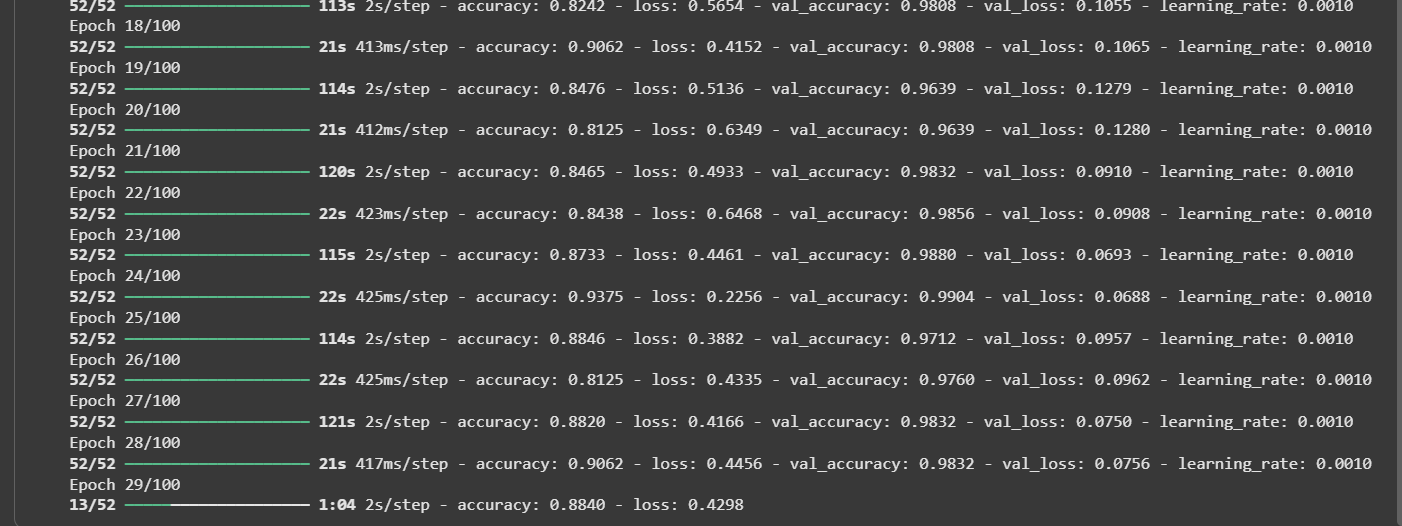

## **Section 6: Evaluation and Analysis (Evaluasi dan Analisis)**

**Penjelasan:** Setelah pelatihan selesai, kita akan mengevaluasi performa model pada data tes. Ini termasuk visualisasi kurva pembelajaran, serta analisis metrik yang lebih detail seperti classification report dan confusion matrix.

### **6.1. Plot Training History (Plot Riwayat Pelatihan)**

**Penjelasan:** Buat plot untuk Accuracy vs Epochs (Training & Validation) dan Loss vs Epochs (Training & Validation) untuk melihat bagaimana model belajar selama pelatihan.

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

### **6.2. Evaluate on Test Data (Evaluasi pada Data Tes)**

**Penjelasan:** Muat bobot model terbaik yang disimpan oleh ModelCheckpoint (jika digunakan) dan gunakan `model.evaluate()` untuk mendapatkan akurasi dan loss final pada data tes.

In [ ]:
# Load the best weights
try:
    model.load_weights(checkpoint_filepath)
    print("Loaded best weights from checkpoint.")
except Exception as e:
    print(f"Could not load model weights: {e}")
    print("Using the weights from the last epoch.")


# Evaluate the model on the test data
print("\nEvaluating the model on the test dataset...")
loss, accuracy = model.evaluate(test_generator)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

### **6.3. Generate Classification Report and Confusion Matrix (Buat Laporan Klasifikasi dan Matriks Kebingungan)**

**Penjelasan:** Dapatkan prediksi untuk seluruh data tes, gunakan `classification_report` untuk melihat metrik per kelas (presisi, recall, f1-score), dan visualisasikan `confusion_matrix` untuk melihat performa per kelas secara detail.

In [ ]:
# Get predictions for the test data
print("\nGenerating predictions for the test dataset...")
test_generator.reset() # Reset generator to ensure data is in order
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes # Use .classes attribute for flow_from_dataframe

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Generate classification report
print("\nClassification Report:")
# Ensure true_classes and predicted_classes have the same number of samples
# This might be an issue if test_generator steps calculation was off or last batch is smaller
# Let's truncate predictions/true_classes if necessary to match
min_samples = min(len(true_classes), len(predicted_classes))
classification_rep = classification_report(true_classes[:min_samples], predicted_classes[:min_samples], target_names=class_labels[:min_samples], zero_division=0)
print(classification_rep)

# Generate confusion matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(true_classes[:min_samples], predicted_classes[:min_samples])

# Plot confusion matrix (optional, for visualization if number of classes is manageable)
# Due to the large number of classes (1602), plotting the full matrix might be too large.
# We will only plot if the number of classes is relatively small.
if NUM_CLASSES <= 50: # Example threshold
    plt.figure(figsize=(15, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print(f"Confusion matrix not plotted due to a large number of classes ({NUM_CLASSES}).")
    print("Confusion Matrix (raw data):")
    print(conf_matrix)

## **Section 7: Fine-Tuning (Opsional, untuk Akurasi Maksimal)**

**Penjelasan:** Jika performa belum maksimal, kita bisa mencoba fine-tuning. Ini melibatkan "membuka" beberapa layer terakhir dari base model pra-latih dan melatihnya kembali dengan learning rate yang sangat kecil.

### **7.1. Unfreeze Layers (Membuka Lapisan)**

**Penjelasan:** Set `base_model.trainable = True`. Tentukan berapa banyak layer dari atas yang ingin di-unfreeze. Membuka terlalu banyak layer bisa menyebabkan overfitting, jadi mulailah dengan membuka beberapa layer terakhir.

In [ ]:
# Unfreeze the base model
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this many layers onwards
fine_tune_from_layer = int(len(base_model.layers) * 0.75) # Example: unfreeze the top 25% layers

# Freeze all the layers before the `fine_tune_from_layer`
for layer in base_model.layers[:fine_tune_from_layer]:
    layer.trainable = False

print(f"\nFreezing layers up to layer {fine_tune_from_layer}. Layers after this will be trainable.")

# Verify which layers are trainable
for layer in model.layers:
    print(f"{layer.name} trainable: {layer.trainable}")
    if hasattr(layer, 'layers'):
        for sub_layer in layer.layers:
            print(f"  {sub_layer.name} trainable: {sub_layer.trainable}")

### **7.2. Re-compile with a Low Learning Rate (Kompilasi Ulang dengan Learning Rate Rendah)**

**Penjelasan:** Kompilasi ulang model dengan optimizer Adam dan `learning_rate` yang jauh lebih kecil (misal, `1e-5`) untuk fine-tuning. Learning rate yang kecil penting untuk menghindari merusak bobot pra-latih yang sudah ada.

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.00001), # Use a very low learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\nModel re-compiled with a lower learning rate for fine-tuning.")

### **7.3. Continue Training (Lanjutkan Pelatihan)**

**Penjelasan:** Latih kembali model untuk beberapa epoch tambahan dengan set learning rate yang baru. Gunakan callbacks yang sama atau sesuaikan jika perlu.

In [ ]:
# Continue training the model with fine-tuning
print("\nContinuing training with fine-tuning...")

# It's often good practice to use a new EarlyStopping callback for fine-tuning
# to monitor improvement in this phase.
fine_tune_early_stopping = EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    patience=5,         # Stop if no improvement for 5 epochs (can be adjusted)
    restore_best_weights=True) # Restore model weights from the epoch with the best value

# We can continue training for a fixed number of epochs or use the original EPOCHS variable
fine_tune_epochs = 50 # Example: train for 50 more epochs with fine-tuning
total_epochs = EPOCHS + fine_tune_epochs # Calculate total epochs if needed

history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=fine_tune_epochs, # Train for fine_tune_epochs more epochs
    initial_epoch=history.epoch[-1] + 1 if history.epoch else 0, # Start from where previous training left off
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[fine_tune_early_stopping, model_checkpoint_callback, reduce_lr_callback] # Use callbacks, maybe adjust patience
)

# Combine history for plotting if needed
# history_combined = {key: history.history[key] + history_fine_tune.history[key] for key in history.history.keys()}

### **7.4. Final Evaluation (Evaluasi Akhir)**

**Penjelasan:** Ulangi langkah evaluasi dari Section 6 untuk melihat peningkatan performa setelah fine-tuning.

In [ ]:
# Load the best weights saved during the combined training and fine-tuning phase
try:
    model.load_weights(checkpoint_filepath)
    print("Loaded best weights from checkpoint after fine-tuning.")
except Exception as e:
    print(f"Could not load model weights after fine-tuning: {e}")
    print("Using the weights from the last epoch of fine-tuning.")

# Evaluate the fine-tuned model on the test data
print("\nEvaluating the fine-tuned model on the test dataset...")
loss_fine_tune, accuracy_fine_tune = model.evaluate(test_generator)

print(f"Test Loss after fine-tuning: {loss_fine_tune:.4f}")
print(f"Test Accuracy after fine-tuning: {accuracy_fine_tune:.4f}")

# Optionally, re-run classification report and confusion matrix after fine-tuning
# (You can copy the code from Section 6.3 here if needed, ensuring test_generator is reset)

### 3.4. Apply the Generators (Menerapkan Generator)

**Penjelasan:** Gunakan `flow_from_dataframe()` untuk memuat gambar dari DataFrame yang telah dibuat. Pastikan DataFrame memiliki kolom untuk path file gambar dan kolom untuk label kelas. Pastikan `target_size`, `batch_size`, dan `class_mode` diatur dengan benar. Karena struktur folder Anda tidak memiliki subdirektori per kelas, kita akan menggunakan `flow_from_dataframe` yang membaca path dan label dari DataFrame. Untuk memastikan generator training dan testing memiliki set kelas yang sama, kita akan menggunakan `class_indices` dari generator training saat membuat generator testing.